In [7]:
using ApproxFun, SingularIntegralEquations, RiemannHilbert, Plots, QuadGK, DualNumbers, ComplexPhasePortrait, LinearAlgebra
import ApproxFunBase: SequenceSpace, BasisFunctional, ℓ⁰, SpaceOperator, piece, pieces, npieces
import ApproxFun: eigs
import ApproxFunOrthogonalPolynomials: Recurrence 
import RiemannHilbert: RiemannDual, logpart, finitepart, istieltjes, LogNumber
import SingularIntegralEquations: ⁺, ⁻
using RiemannHilbert.KdV

## The direct scattering transform

We first consider calculation of discrete spectrum of Schrödinger:
$$
\psi'' + V(x) \psi = \lambda \psi
$$

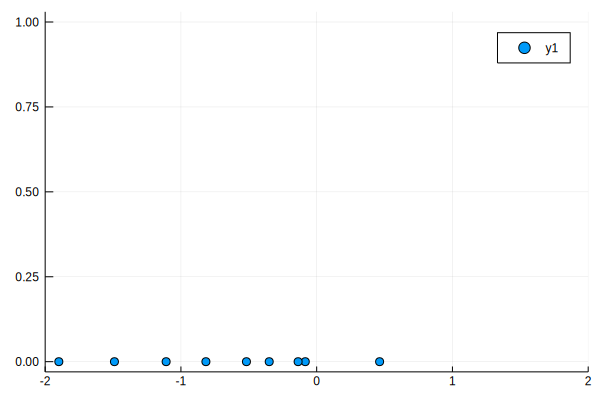

In [4]:
V = x -> 1.2exp(-x^2)
d = -10..10 # computational domain
D = Derivative()

λ,Q = eigs(Dirichlet(d), D^2 + Fun(V,d), 500)
scatter(λ, zero.(λ); xlims=(-2,2))

Associated with the continuous spectrum is the reflection coefficient. This can be calculated:

In [5]:
R = ReflectionCoefficient( x -> 1.2exp(-x^2))
@time R(0.1)

 19.831116 seconds (32.77 M allocations: 1.617 GiB, 6.12% gc time)


-0.9651837057640016 + 0.06801873361190361im

Behind the scenes, its solving an ODE for $\psi$ on (-∞,0] and $\phi_\pm$ on [0,∞), by truncating the domain:

  0.029356 seconds (161.25 k allocations: 6.126 MiB)


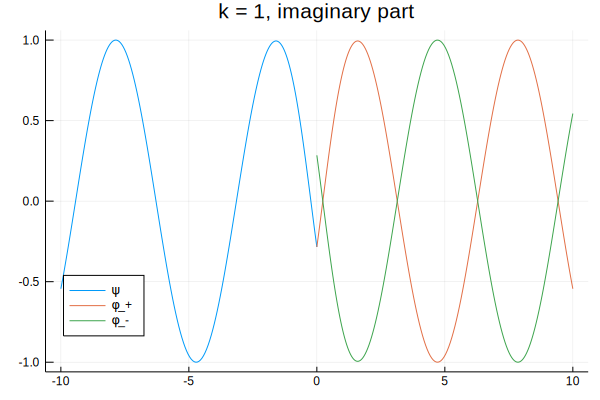

In [8]:
M = 10
V = x -> 1.2exp(-x^2)
V₋,V₊ = Fun(V, (-M)..0), Fun(V, 0..M)

k = 1
@time ψ = [ivp(); D^2  + (V₋ + k^2)] \ [exp(-im*k*(-M)), -im*k*(exp(-im*k*(-M))), 0.0]

F = qr([rdirichlet(space(V₊)); rneumann(); D^2  + (V₊ + k^2)])
φ₊ = F \ [exp(im*k*M), im*k*(exp(im*k*M)), 0.0]
φ₋ = F \ [exp(-im*k*M), -im*k*(exp(-im*k*M)), 0.0]

plot(imag(ψ); legend=:bottomleft, label="\\psi", title="k = $k, imaginary part") 
plot!(imag(φ₊); label="\\phi\\_+")
plot!(imag(φ₋); label="\\phi\\_-")

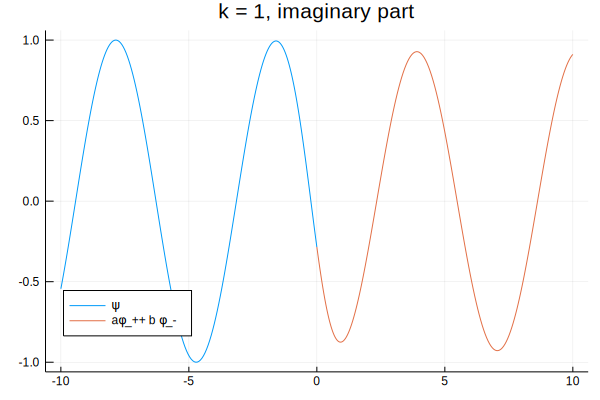

In [9]:
a,b = [φ₋(0) φ₊(0);
       φ₋'(0) φ₊'(0) ] \ [ψ(0); ψ'(0)]

plot(imag(ψ); legend=:bottomleft, label="\\psi", title="k = $k, imaginary part") 
plot!(imag(a*φ₋ + b*φ₊); label="a\\phi\\_+ + b\\phi\\_-")

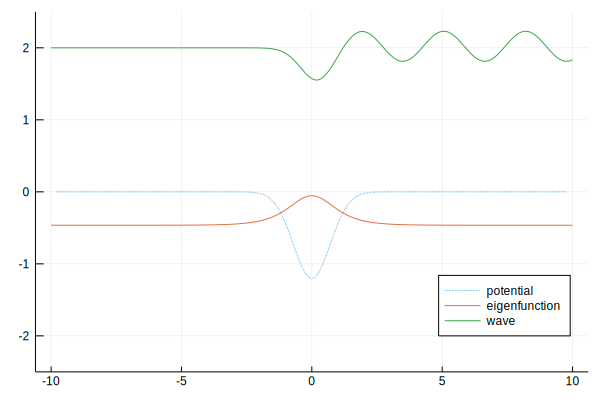

In [10]:
q = Q[findmax(λ)[2]]
q = q/norm(q)
plot(x -> -V(x), -10,10; label="potential",  legend=:bottomright, ylims=(-2.5,2.5), linestyle=:dot)
plot!(-findmax(λ)[1]+abs2(q); label="eigenfunction")
plot!(abs2(ψ+a*φ₋ + b*φ₊)+k; label="wave")

## The inverse scattering transform

With $R$ we have han efficient way of calculating reflection coefficients. We now see how to solve the Riemann–Hilbert problem, but lets simplify things so that we only have continuous spectrum:

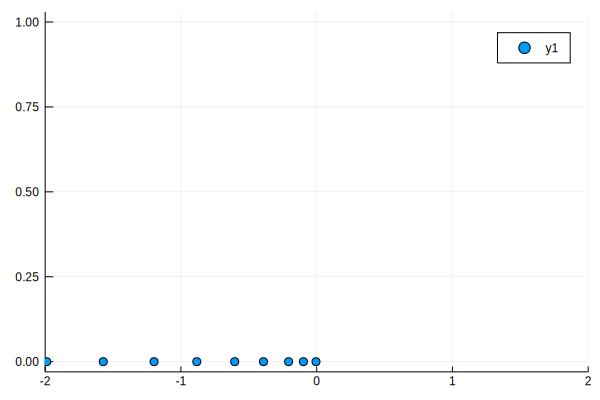

In [11]:
V = x -> 0.1exp(-x^2)
d = -10..10 # computational domain
D = Derivative()

λ,Q = eigs(Dirichlet(d), D^2 + Fun(V,d), 500)
scatter(λ, zero.(λ); xlims=(-2,2))

The first step is to expand $R$ into a Chebyshev expansion. We use `tFun` which takes advantage of parallelisation:

 16.375637 seconds (93.58 M allocations: 2.975 GiB, 10.56% gc time)


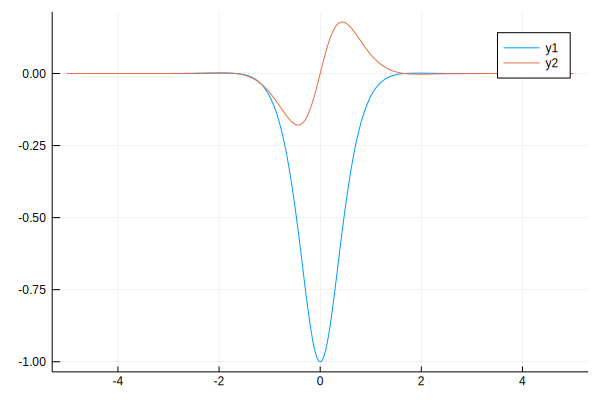

In [17]:
@time ρ = tFun(R, -5.0..5, 300)
plot(ρ)

For any $t$ and $x$ we can construct the jump function, but we would need to deform for large $t$ and $x$. Lets keep life simple and take $t = x = 0$, in which case we get the following jump:

In [18]:
k = Fun(identity, space(ρ))
G = [1-abs2.(ρ) -conj.(ρ);
        ρ           1.0];

We can now find the solution to $\Phi_+ = \Phi_- G$. RiemannHilbert.jl uses the transpose version ($\Phi_+ = G \Phi_-$) so we transpose twice:

In [19]:
@time Φ = transpose(rhsolve(transpose(G), 2*4*200)); # asymptotic to I
Φ = [1 1]*Φ; # asymptotic to [1 1]

 67.212428 seconds (79.55 M allocations: 4.182 GiB, 3.72% gc time)


It worked!

In [20]:
Φ(0.1+0.0im) ≈ Φ(0.1-0.0im)*G(0.1)

true

We can then recover $V$ from `Φ`. I'm not going to show that since there's a bug 😳

In [21]:
ψ(0.0)/a - (φ₋(0.0) + ρ(1)*φ₊(0.0))

-2.220446049250313e-16 + 1.0547118733938987e-15im

In [22]:
Φ(1.0-0.0im)

1×2 Array{Complex{Float64},2}:
 1.05043-0.372028im  0.942763+0.332064im

In [23]:
Φ(1.0+0.0im)

1×2 Array{Complex{Float64},2}:
 0.942763-0.332064im  1.05043+0.372028im

In [24]:
R(1)

-0.07910491062180808 + 0.06606135311851252im

In [25]:
ψ(0.0)/a

0.6642329847792622 + 0.3535499072338503im

In [33]:
(ϕ₋)(0.0)

UndefVarError: UndefVarError: ϕ₋ not defined

In [34]:
ϕ₊(0.0)

UndefVarError: UndefVarError: ϕ₊ not defined

In [35]:
S = []

0-element Array{Any,1}

In [36]:
ψ(-10.0)exp(im*1*(-10.0))

1.0000000000000007 + 5.551115123125783e-17im

In [37]:
Φ(1-0.0im)

1×2 Array{Complex{Float64},2}:
 1.05043-0.372028im  0.942763+0.332064im

In [38]:
ϕ₊(0.0) 

UndefVarError: UndefVarError: ϕ₊ not defined

In [39]:
ϕ₋(1)

UndefVarError: UndefVarError: ϕ₋ not defined